# Main ePodium Notebook

1. [Loading EEG-data and metadata](#1)
2. [ePodium Events](#2)
3. [The Experiment](#3)
4. [Processing](#4)
5. [Analysing event related potentials](#5)

#### Import Packages

In [1]:
import mne
import numpy as np
import os
import glob
import ipywidgets
import wave # For analyzing .wav audio files

from functions import data
from functions import processing
from functions import display_helper

from functions.epodium import Epodium
epodium = Epodium()

import local_paths

<br>

<a id='1'></a>
## 1. Loading EEG-data and metadata

   Make sure *local_paths.ePod_dataset* contains the path to the __dataset__ and *local_paths.ePod_metadata* contains the __metadata__ files.

* *children.txt* contains the age and sex, and risk of dyslexia due to at least 1 dyslexic parents.
* *cdi.txt* contains aditional information about the child's vocabulary with the Communicative Development Inventories questionnaire
* *parents.txt* contains info on dyslexia tests and diagnoses of the parents.
* *CODES_overview* contains the mapping of event condition and stimulus to an event number.

In [2]:
experiments_raw, experiments_id = data.load_raw_dataset(local_paths.ePod_dataset, 
                                                       file_extension='.bdf', 
                                                       preload=False)

epod_children, epod_cdi, epod_parents, epod_codes = data.load_metadata(local_paths.ePod_metadata,
                                                                       epodium.metadata_filenames)

248 EEG files loaded


#### Participants Info

In [3]:
clean_b_dataframe = epod_children.loc[epod_children['Age_days_b'].str.isnumeric()]

print(f"The participants are between the age of {epod_children['Age_days_a'].min()} "
      f"and {int(clean_b_dataframe['Age_days_b'].max())} days. "
      f"({round(epod_children['Age_months_a'].min(), 1)} to "
      f"{float(clean_b_dataframe['Age_months_b'].max())} months)")

The participants are between the age of 487 and 756 days. (16.2 to 25.2 months)


<br>

<a id='2'></a>
## 2. ePodium Events

    The ePodium experiment is an *auditory oddball experiment*. Children listen to a sequence that contains __80% standard__ and __20%     deviant__ syllables in order to elicit the *mismatch response*. 
    For measurement 34 electrodes are used, of which __32 channels__ and 2 mastoid references. The measurement frequency is __2048.0 Hz__. 
    Each test is around __30 minutes__, with sequences of around 7.5 minutes containing four different conditions:

+ Condition 1 __GiepMT__: standard "*giep*", deviant "*gip*": multiple pronounciations 
+ Condition 2 __GiepST__: standard "*giep*", deviant "*gip*": single pronounciation 
+ Condition 3 __GopMT__: standard "*gop*", deviant "*goep*": multiple pronounciations 
+ Condition 4 __GopST__: standard "*gop*", deviant "*goep*": single pronounciation

#### Analyse audio stimulus

In [4]:
def print_sound_duration(sounds):
    path_sound = os.path.join(local_paths.ePod_metadata, 'sounds', sounds)
    with wave.open(path_sound) as mywav:
        duration_seconds = mywav.getnframes() / mywav.getframerate()
        print(f"Length of the WAV file: {duration_seconds:.3f} s")
        
epod_sounds = sorted(os.listdir(os.path.join(local_paths.ePod_metadata, 'sounds')))
ipywidgets.interact(print_sound_duration, sounds=epod_sounds);

interactive(children=(Dropdown(description='sounds', options=('giep_s02.wav', 'giep_s03.wav', 'giep_s05.wav', …

### Load events
Events are stored into external .txt file for faster loading.


In [5]:
## Store events in local path
n_events_stored = len(glob.glob(os.path.join(local_paths.ePod_events, '*.txt')))
if n_events_stored != len(experiments_raw):
    data.save_events(local_paths.ePod_events, experiments_raw, experiments_id)

## Load events
events = data.load_events(local_paths.ePod_events, experiments_id)

## Set multiple pronounciations as same event id to reduce the unique events from 78 to 12.
events_12 = epodium.group_events_12(events)

248 Event Marker files loaded


<br>

<a id='3'></a>
## 3. The Experiment

#### Choose which participant to analyse

In [6]:
def f(experiments):
    return experiments

participant_widget = ipywidgets.interactive(f, experiments=sorted(experiments_id))
display(participant_widget)

interactive(children=(Dropdown(description='experiments', options=('101a', '101b', '102a', '102b', '103a', '10…

#### Show part of the EEG signal
When a new experiment is chosen, this cell needs to be run again to visualise its EEG data.

Using matplotlib as 2D backend.
Opening raw-browser...


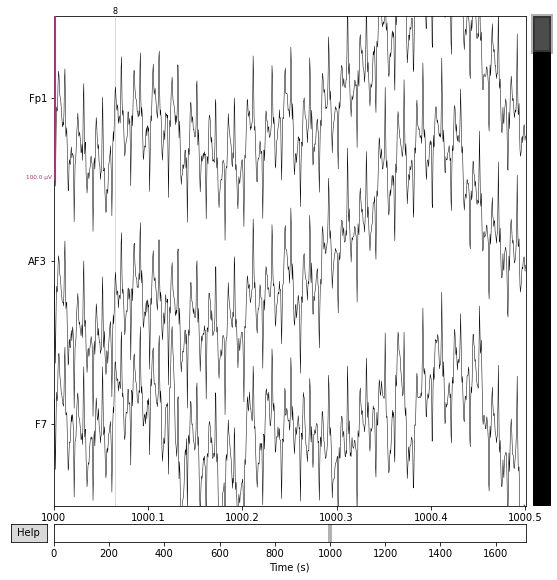

In [7]:
## Makes the plot interactive, comment out if not working:
# %matplotlib widget 

participant_raw = experiments_raw[experiments_id.index(participant_widget.result)]
participant_events = events_12[experiments_id.index(participant_widget.result)]

fig = mne.viz.plot_raw(participant_raw, participant_events, n_channels = 3, 
                       scalings = 50e-6, duration = 0.5, start = 1000)

#### Plot events across time

The events are grouped into __12 event types__, 3 for each condition. 

Ideally, each condition has __120 deviants__ (D) and __360 standards__ (S).

The test also contains __first standards__ (FS) to make the child accustomed to the standard. First standards are discarded when calculating the mismatch response. 

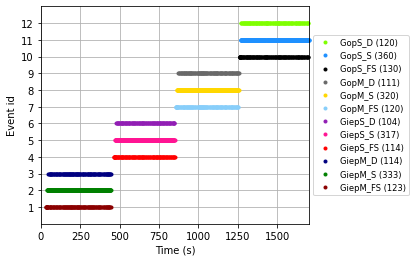

In [8]:
fig = mne.viz.plot_events(participant_events, event_id=epodium.event_dictionary, 
                          color=display_helper.color_dictionary, sfreq=epodium.frequency)

<br>

<a id='4'></a>
## 4. Processing
#### Filtering ePodium dataset and rejecting bad trials

The EEG data located in _local_paths.ePod_dataset_ is cleaned with the following techniques:
+ A high-pass filter on the raw EEG sequence with cutoff frequency 0.1 Hz to remove slow trends
+ Splitting the raw data into 1 second epochs in which the event occurs at 0.2s.
+ The epochs are cleaned with the autoreject library. This library contains classes that automatically reject bad trials and repair bad sensors in EEG data. The AutoReject and Ransac classes are used. https://autoreject.github.io/stable/index.html
+ A low-pass filter on the epochs 

The function process_raw splits the raw files up into epochs and saves the events externally. It takes a while to process each file, mainly due to the complexity of the autoreject method. To save some time, multiple raw files are processed simultaniously via multiprocessing.

In [9]:
raw_paths = sorted(glob.glob(os.path.join(local_paths.ePod_dataset, '*' + epodium.file_extension)))

# for raw_path in raw_paths:
#     processing.process_raw(raw_path, epodium, local_paths.ePod_processed)

## Multiprocessing:
processing.process_raw_multiprocess(raw_paths, epodium, local_paths.ePod_processed)

All files processed


#### Extract valid experiments
Processed files with too few standards and deviants are considered invalid.

In [14]:
directory_events = os.path.join(local_paths.ePod_processed, "events")
valid_experiments = processing.valid_experiments(directory_events,
                                                 min_standards = 180, 
                                                 min_deviants = 80)

Analyzed: 229, bad: 43
186 experiments have enough epochs for analysis.


<br>

<a id='5'></a>
## 5. Analysing event related potentials (ERPs)

    The voltage change in the brain as a response to an event is called the *event-related potential* (ERP)
    The response difference between a standard and deviant ERP is called the *mismatch response* (MMR).
    The mismatch response can be analysed to predict differences between participants.


#### Choose experiment to analyse

In [11]:
def load_participant_data(experiment):
    global epochs
    epochs = mne.read_epochs(os.path.join(local_paths.ePod_processed, experiment + "_epo.fif"), verbose = 0)
    print(f"Loaded experiment: {experiment} ")

ipywidgets.interact(load_participant_data, experiment=valid_experiments);

interactive(children=(Dropdown(description='experiment', options=('101a', '101b', '102a', '102b', '103b', '104…

#### Widget for plotting standard, deviant, and mismatch ERPs

In [12]:
condition = ipywidgets.RadioButtons(options=epodium.conditions, 
                                    description='Condition:',
                                    value="GiepM")
event_type = ipywidgets.RadioButtons(options=["standard", "deviant", "MMN"], 
                                     description='Event type:', 
                                     value="standard")

def plot_ERP_widget(con, ev):
    display_helper.plot_ERP(epochs, con, ev)

ui = ipywidgets.HBox([condition, event_type])
out = ipywidgets.interactive_output(plot_ERP_widget, {'con': condition, 'ev': event_type})
display(ui, out)

Output()

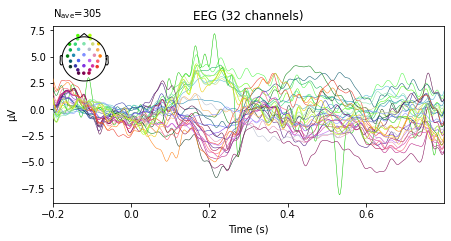

In [16]:
display_helper.plot_ERP(epochs, "GiepM", "standard")